In [25]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches

In [26]:
from lightning_threshold_innercore_function_only import *

In [27]:
rainband_shear_timebin_joined = pd.read_csv(r"C:\Users\user\Desktop\GitHub\Lightning_Analysis_NWRA\data_pipeline\rainband_shear_timebin_joined.csv")
rainband_shear_timebin_joined = pl.from_pandas(rainband_shear_timebin_joined)

In [28]:
rainband_shear_timebin_joined.head()

time_bin,shear_quad,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,24_hour_knots_diff,24_hour_pressure_diff,TC_Category,Intensification_Category
str,str,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,f64,f64,str,str
"""2010-06-25 15:00:00""","""DL""","""ATL_10_1""",75,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""
"""2010-06-25 15:00:00""","""DR""","""ATL_10_1""",11,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""
"""2010-06-25 15:00:00""","""UL""","""ATL_10_1""",0,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""
"""2010-06-25 15:00:00""","""UR""","""ATL_10_1""",26,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""
"""2010-06-25 15:30:00""","""DL""","""ATL_10_1""",2,2010,6,25,15,30,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""


In [29]:
# import data from csv file
rainband_shear_timebin_joined = rainband_shear_timebin_joined.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
rainband_shear_timebin_joined = rainband_shear_timebin_joined.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
rainband_shear_timebin_joined = rainband_shear_timebin_joined.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
rainband_shear_timebin_joined.head()


time_bin,shear_quad,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count
datetime[μs],str,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,f64,f64,str,str,f64
2010-06-25 15:00:00,"""DL""","""ATL_10_1""",75,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",4.330733
2010-06-25 15:00:00,"""DR""","""ATL_10_1""",11,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",2.484907
2010-06-25 15:00:00,"""UL""","""ATL_10_1""",0,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",0.0
2010-06-25 15:00:00,"""UR""","""ATL_10_1""",26,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",3.295837
2010-06-25 15:30:00,"""DL""","""ATL_10_1""",2,2010,6,25,15,30,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",1.098612


In [30]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
rainband_shear_timebin_joined = rainband_shear_timebin_joined.with_columns(
    rainband_shear_timebin_joined["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

rainband_shear_timebin_joined.head()

time_bin,shear_quad,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count,Intensification_Category_3
datetime[μs],str,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,f64,f64,str,str,f64,str
2010-06-25 15:00:00,"""DL""","""ATL_10_1""",75,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",4.330733,"""Intensifying"""
2010-06-25 15:00:00,"""DR""","""ATL_10_1""",11,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",2.484907,"""Intensifying"""
2010-06-25 15:00:00,"""UL""","""ATL_10_1""",0,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",0.0,"""Intensifying"""
2010-06-25 15:00:00,"""UR""","""ATL_10_1""",26,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",3.295837,"""Intensifying"""
2010-06-25 15:30:00,"""DL""","""ATL_10_1""",2,2010,6,25,15,30,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",1.098612,"""Intensifying"""


In [31]:
storm_names = rainband_shear_timebin_joined[["storm_code", "storm_name"]].unique()

In [32]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = rainband_shear_timebin_joined.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

# Apply functions to data, including bins with 0 lightning
bursts_w_0 = apply_individual_thresholds(pd_data)

tc_summary_w_0 = create_tc_summary(bursts_w_0)
tc_summary_w_0.head(10)

# Get mean threshold value for each of the 6 options
tc_summary_w_0_mean = tc_summary_w_0.drop(columns=("storm_code")).mean()
print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# Get median threshold value for each of the 6 options
tc_summary_w_0_median = tc_summary_w_0.drop(columns=("storm_code")).median()
print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

# Get mean threshold value for each of the 6 options
tc_summary_w_0_mean = tc_summary_w_0.drop(columns=("storm_code")).mean()
print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# Get median threshold value for each of the 6 options
tc_summary_w_0_median = tc_summary_w_0.drop(columns=("storm_code")).median()
print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

c:\Users\user\Desktop\GitHub\Lightning_Analysis_NWRA\innercore_analysis\lightning_threshold_innercore_function_only.py:161: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  bursts = df.groupby(["storm_code"]).apply(detect_bursts_iqr)
c:\Users\user\Desktop\GitHub\Lightning_Analysis_NWRA\innercore_analysis\lightning_threshold_innercore_function_only.py:163: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=Fa

mad1_threshold     0.668586
mad2_threshold     0.801124
iqr1_threshold     1.869827
iqr2_threshold     2.336712
logn1_threshold    2.879543
logn2_threshold    3.983364
dtype: float64
mad1_threshold     0.000000
mad2_threshold     0.000000
iqr1_threshold     1.386294
iqr2_threshold     1.732868
logn1_threshold    2.684268
logn2_threshold    3.770915
dtype: float64
mad1_threshold     0.668586
mad2_threshold     0.801124
iqr1_threshold     1.869827
iqr2_threshold     2.336712
logn1_threshold    2.879543
logn2_threshold    3.983364
dtype: float64
mad1_threshold     0.000000
mad2_threshold     0.000000
iqr1_threshold     1.386294
iqr2_threshold     1.732868
logn1_threshold    2.684268
logn2_threshold    3.770915
dtype: float64


<Figure size 1000x500 with 0 Axes>

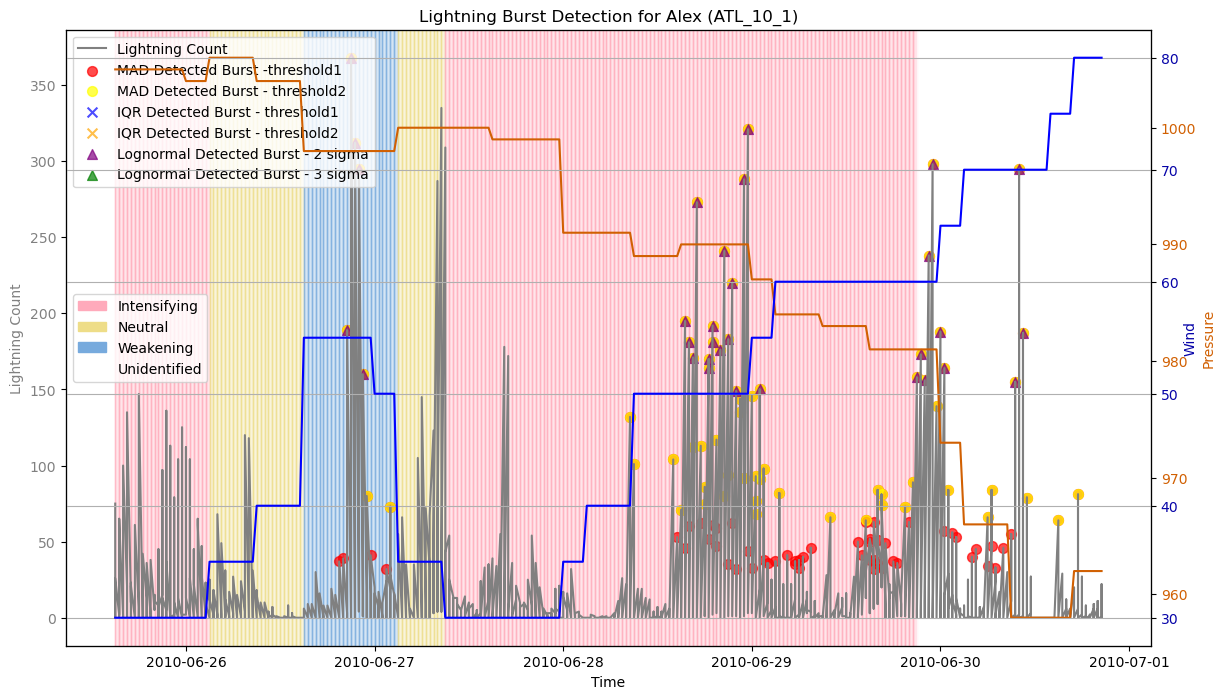

<Figure size 1000x500 with 0 Axes>

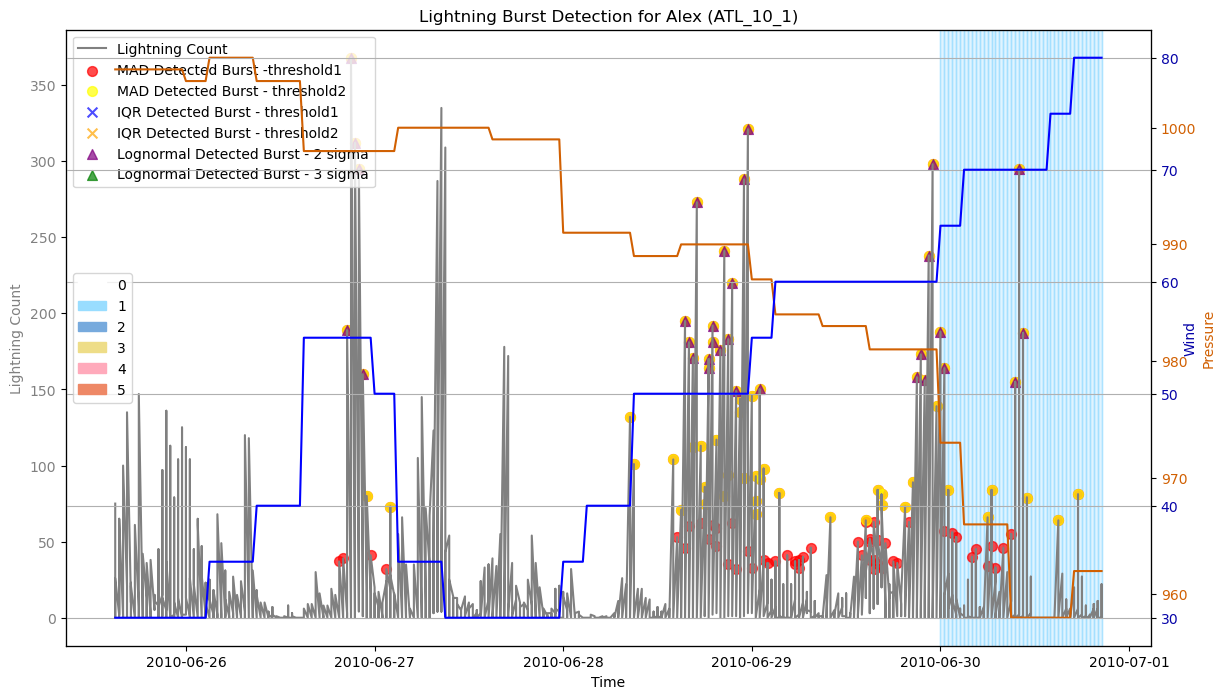

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,121,68,3.465736,4.158883,0,0,5.914525,7.393156,31,0,5.000153,6.718335,672,18.01,10.12,0.0,0.0,4.61,0.0


In [33]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary_w_0[tc_summary_w_0["storm_code"] == cyclone_id]

In [34]:
# Apply functions to data(exclude 0 lightning count)
pd_data_drop0 = pd_data[pd_data['lightning_count'] != 0]

bursts = apply_individual_thresholds(pd_data_drop0)

tc_summary = create_tc_summary(bursts)
tc_summary = pd.merge(storm_names.to_pandas(), tc_summary, on="storm_code")
tc_summary.head(10)

c:\Users\user\Desktop\GitHub\Lightning_Analysis_NWRA\innercore_analysis\lightning_threshold_innercore_function_only.py:161: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  bursts = df.groupby(["storm_code"]).apply(detect_bursts_iqr)
c:\Users\user\Desktop\GitHub\Lightning_Analysis_NWRA\innercore_analysis\lightning_threshold_innercore_function_only.py:163: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=Fa

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_20,Shary,0,0,5.537397,6.346100,2,1,4.552625,5.344208,...,0,4.789575,6.007707,40,0.00,0.00,5.00,2.50,2.50,0.00
1,SHEM_16_13,Uriah,2,0,2.720473,3.125938,2,1,2.525729,2.983874,...,0,2.599743,3.271242,37,5.41,0.00,5.41,2.70,5.41,0.00
2,IO_10_1,Laila,11,9,4.382027,5.075174,13,11,3.701302,4.453341,...,7,4.108790,5.273846,219,5.02,4.11,5.94,5.02,5.48,3.20
3,SHEM_12_10,Jasmine,23,19,2.720473,3.125938,7,1,3.583519,4.306112,...,0,3.440627,4.394360,171,13.45,11.11,4.09,0.58,5.26,0.00
4,WPAC_17_33,Tembin,34,7,5.274601,6.190892,13,0,5.823046,7.105521,...,0,5.640294,7.322466,409,8.31,1.71,3.18,0.00,5.13,0.00
5,WPAC_12_2,Pakhar,0,0,7.555157,8.707837,4,0,6.111694,7.237258,...,0,5.746339,7.209726,236,0.00,0.00,1.69,0.00,3.81,0.00
6,WPAC_17_27,Saola,6,6,2.720473,3.125938,6,2,2.890372,3.439678,...,1,2.946041,3.747944,95,6.32,6.32,6.32,2.11,6.32,1.05
7,ATL_10_7,Earl,0,0,7.567632,8.799776,0,0,6.182085,7.381033,...,0,5.523641,6.943322,794,0.00,0.00,0.00,0.00,1.64,0.00
8,EPAC_12_16,Paul,0,0,5.111313,5.986782,4,2,3.972567,4.716398,...,1,3.897671,4.940430,144,0.00,0.00,2.78,1.39,3.47,0.69
9,SHEM_10_21,Imani,0,0,2.720473,3.125938,0,0,2.525729,2.983874,...,0,2.175650,2.650946,30,0.00,0.00,0.00,0.00,0.00,0.00


<Figure size 1000x500 with 0 Axes>

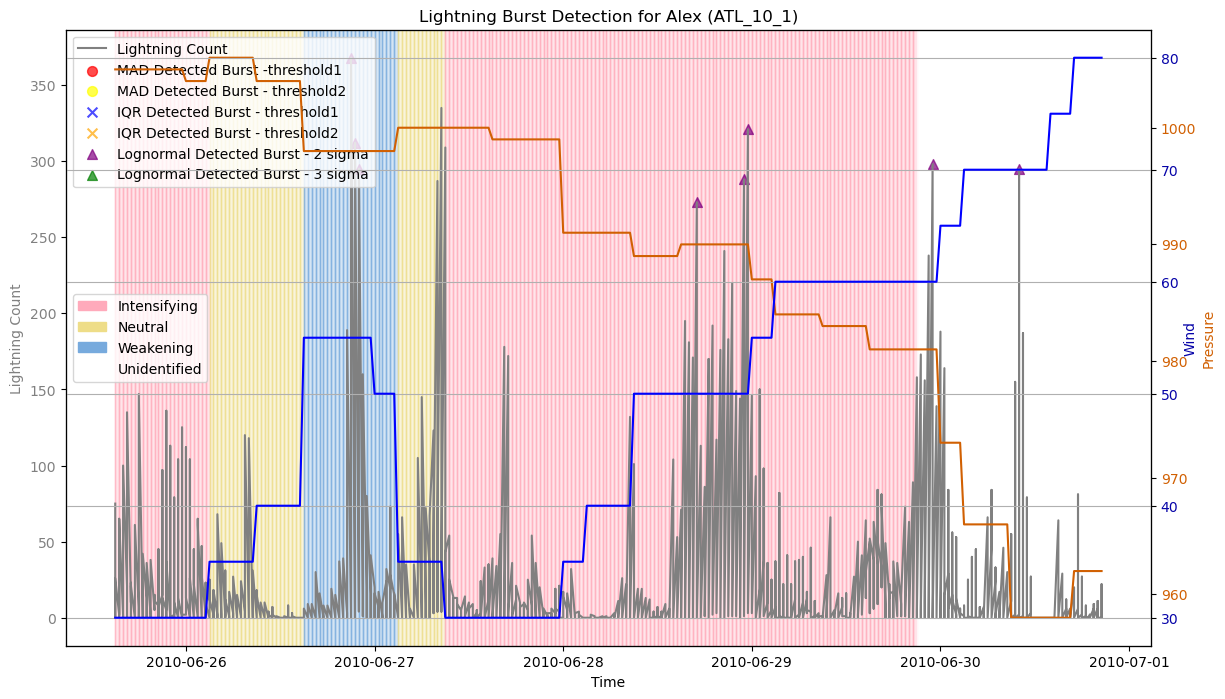

<Figure size 1000x500 with 0 Axes>

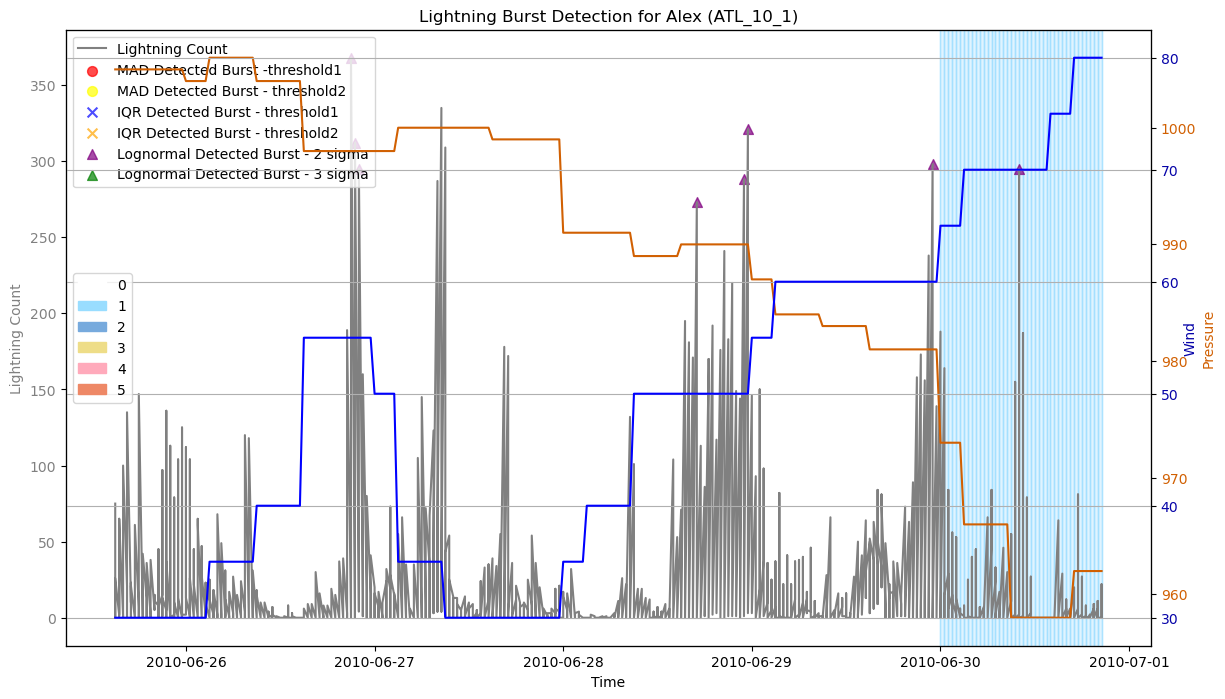

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
223,ATL_10_1,Alex,0,0,7.397394,8.586978,0,0,6.04085,7.204489,...,0,5.54689,6.969608,389,0.0,0.0,0.0,0.0,2.06,0.0


In [35]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

In [54]:
rainband_shear_timebin_joined_pd = rainband_shear_timebin_joined.to_pandas()
filtered_df = rainband_shear_timebin_joined_pd[rainband_shear_timebin_joined_pd['storm_code'].str.contains('^EPAC')]
filtered_df

,time_bin,shear_quad,storm_code,lightning_count,year,month,day,hour,minute,lat,...,knots,storm_name,category,basin,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count,Intensification_Category_3
78400,2010-06-18 15:00:00,DL,EPAC_10_4,0,2010,6,18,15,0,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,0.000000,Intensifying
78401,2010-06-18 15:00:00,DR,EPAC_10_4,0,2010,6,18,15,0,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,0.000000,Intensifying
78402,2010-06-18 15:00:00,UL,EPAC_10_4,3,2010,6,18,15,0,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,1.386294,Intensifying
78403,2010-06-18 15:00:00,UR,EPAC_10_4,0,2010,6,18,15,0,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,0.000000,Intensifying
78404,2010-06-18 15:30:00,DL,EPAC_10_4,0,2010,6,18,15,30,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,0.000000,Intensifying
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139647,2017-07-29 01:00:00,UR,EPAC_17_9,0,2017,7,29,1,0,20.0,...,55,Hilary,2,EPAC,NaN,NaN,0,Unidentified,0.000000,Unidentified
139648,2017-07-29 01:30:00,DL,EPAC_17_9,0,2017,7,29,1,30,20.0,...,55,Hilary,2,EPAC,NaN,NaN,0,Unidentified,0.000000,Unidentified
139649,2017-07-29 01:30:00,DR,EPAC_17_9,0,2017,7,29,1,30,20.0,...,55,Hilary,2,EPAC,NaN,NaN,0,Unidentified,0.000000,Unidentified
139650,2017-07-29 01:30:00,UL,EPAC_17_9,1,2017,7,29,1,30,20.0,...,55,Hilary,2,EPAC,NaN,NaN,0,Unidentified,0.693147,Unidentified


<Figure size 1000x500 with 0 Axes>

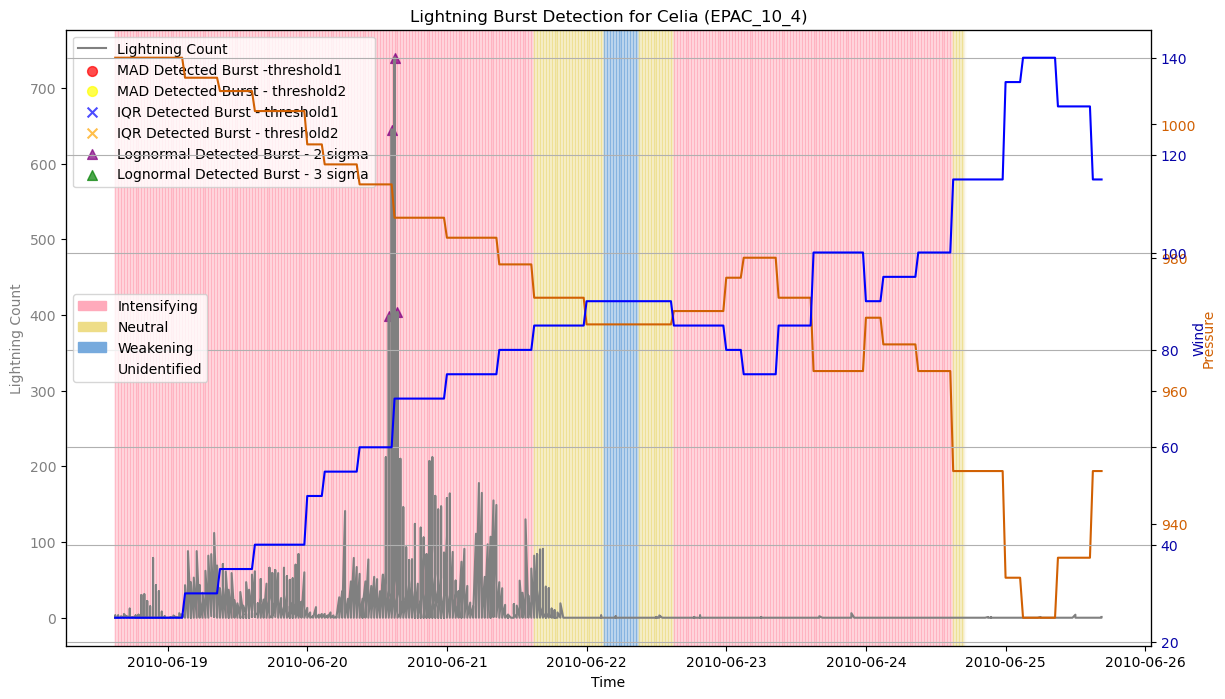

<Figure size 1000x500 with 0 Axes>

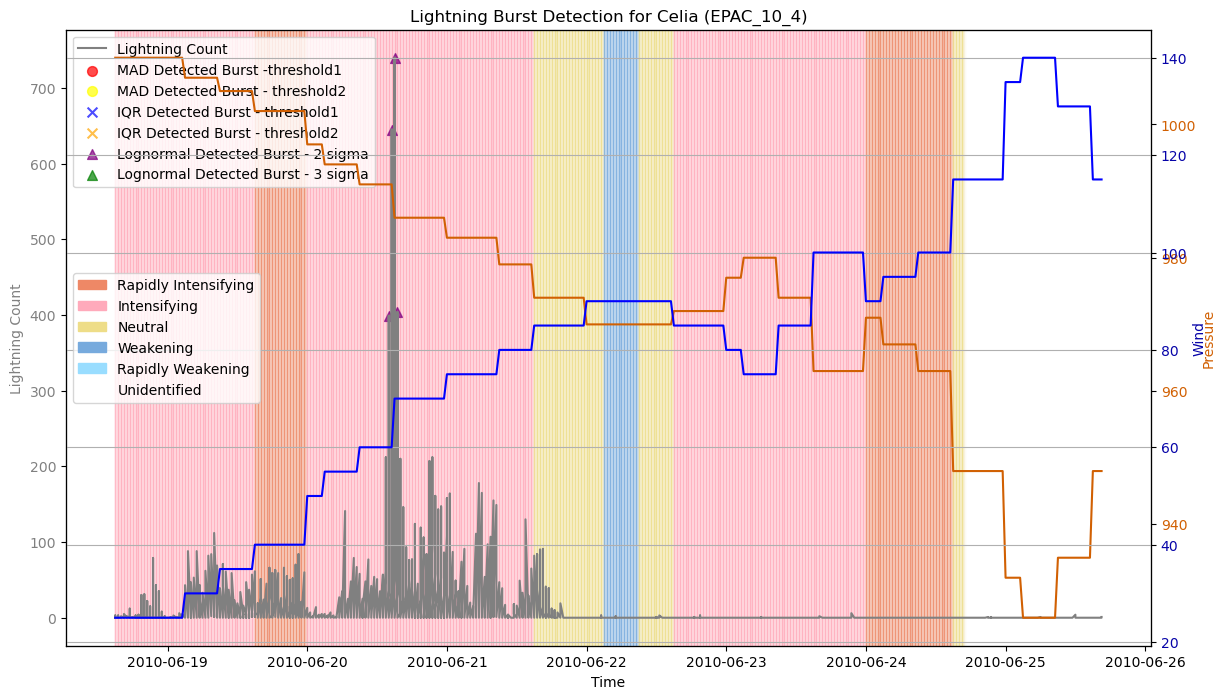

<Figure size 1000x500 with 0 Axes>

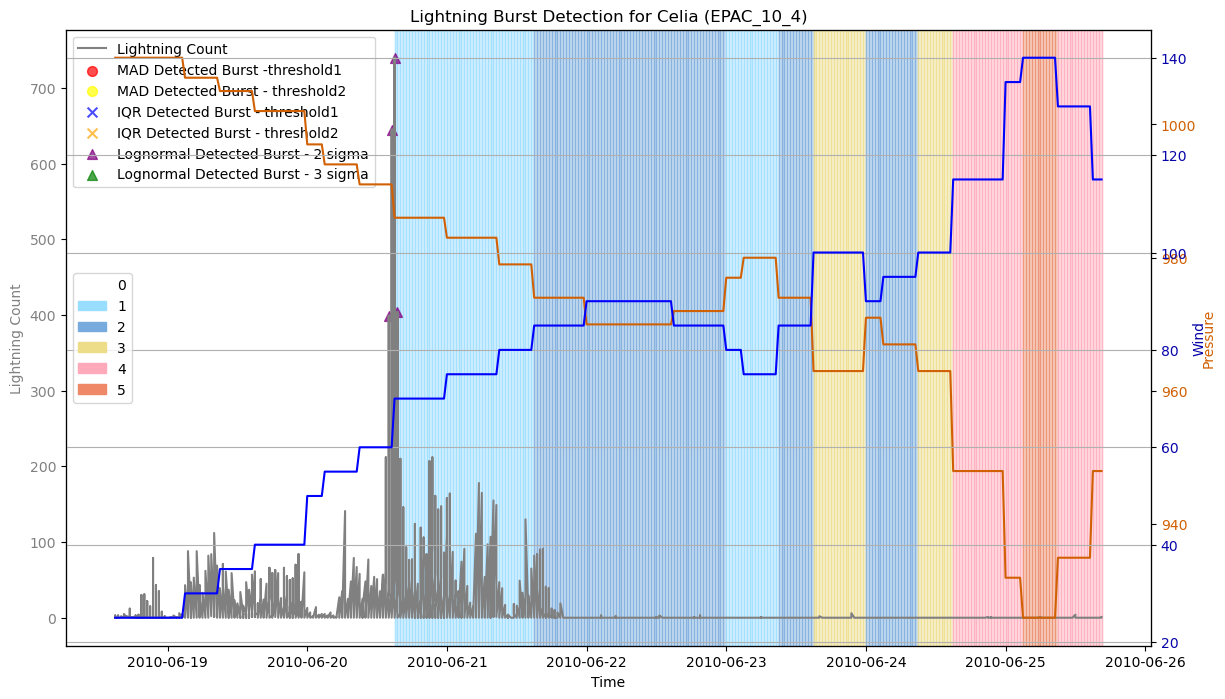

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
290,EPAC_10_4,Celia,0,0,8.020353,9.241567,0,0,6.768781,8.114402,...,0,5.89286,7.389035,229,0.0,0.0,0.0,0.0,1.75,0.0


In [55]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_10_4'
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

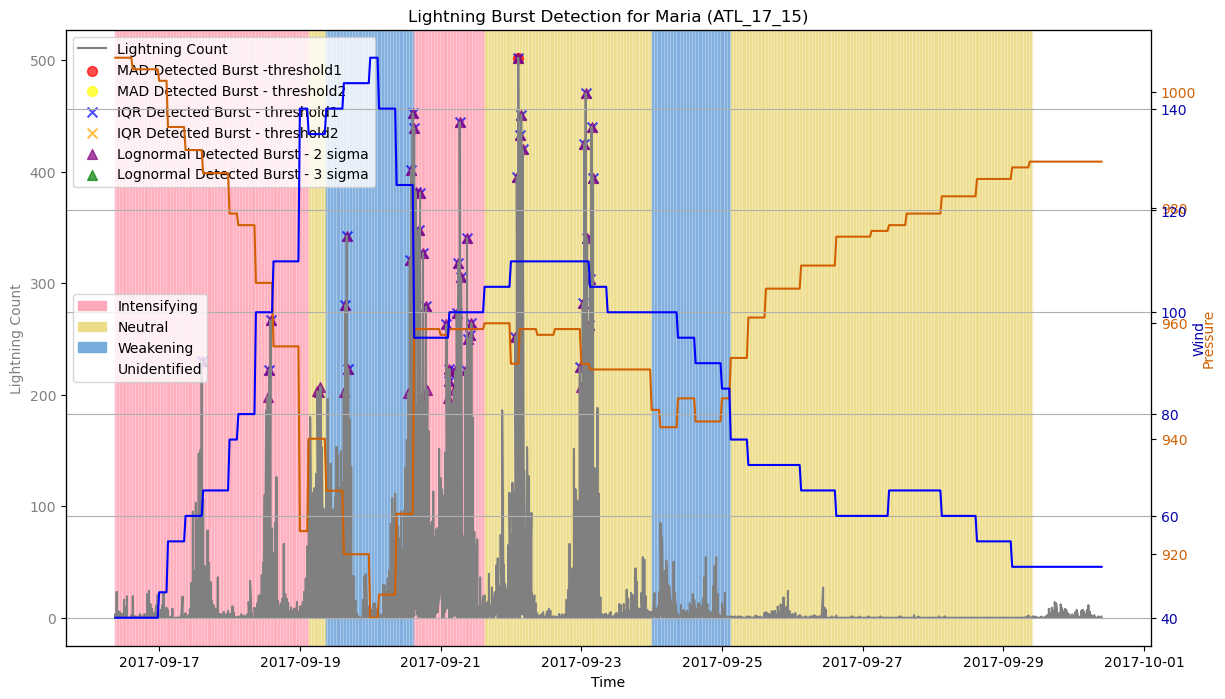

<Figure size 1000x500 with 0 Axes>

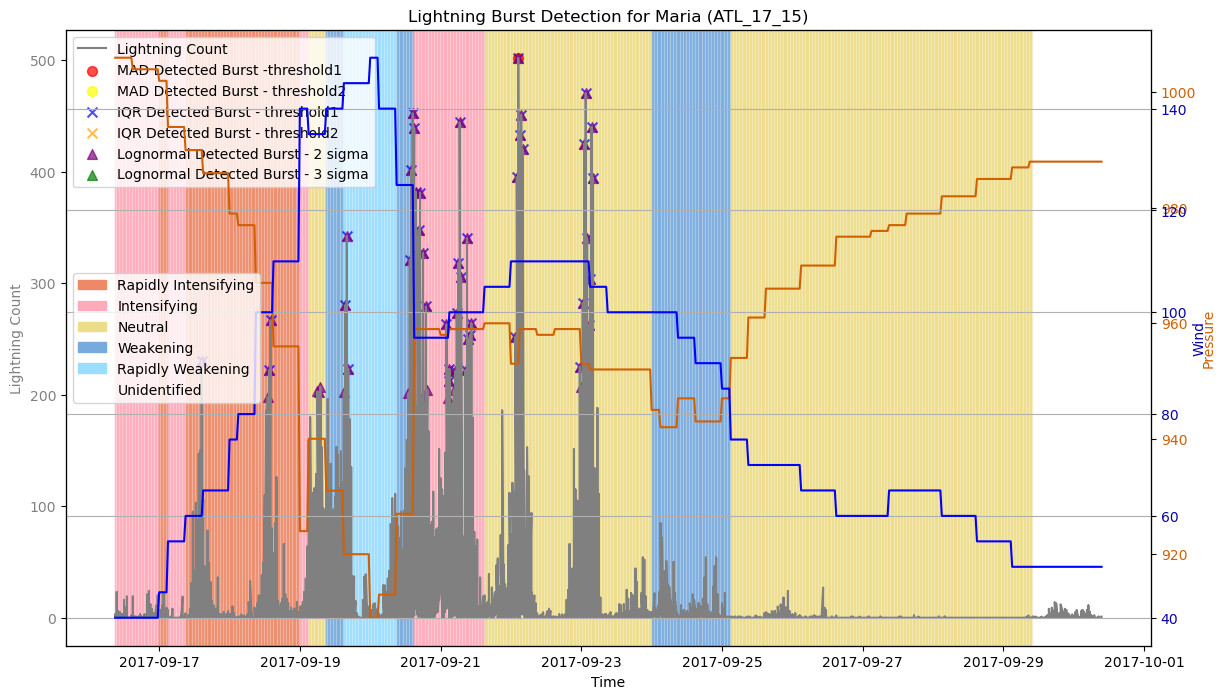

<Figure size 1000x500 with 0 Axes>

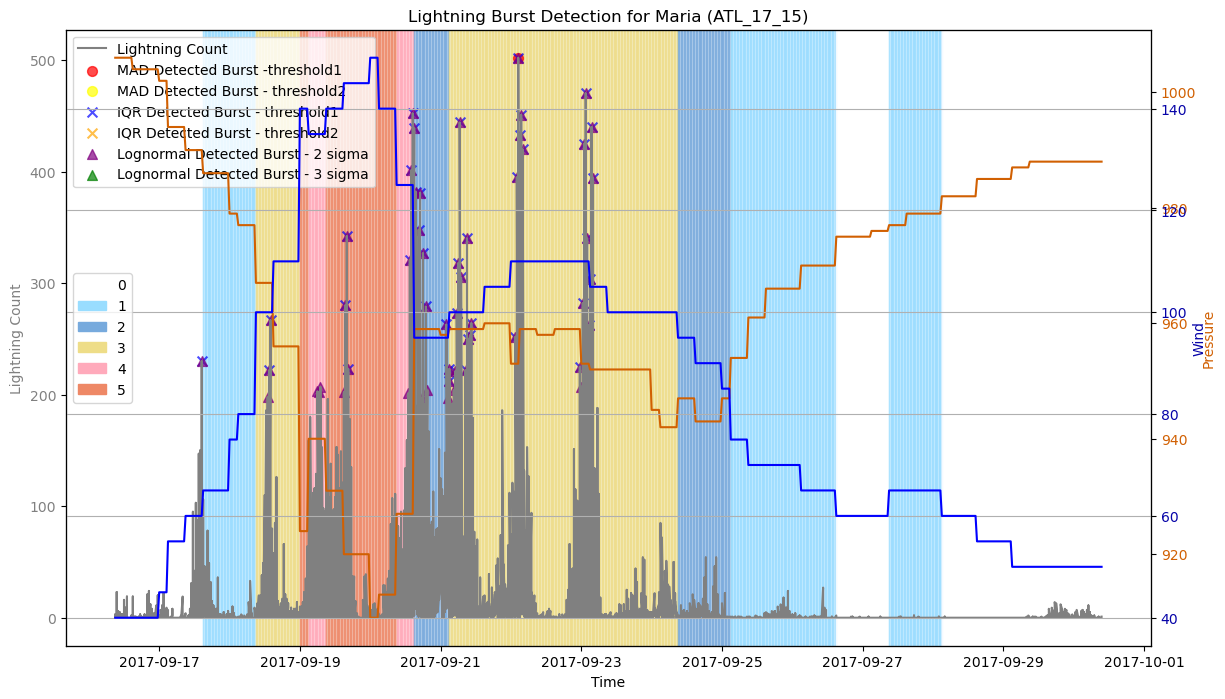

,storm_code,storm_name,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
169,ATL_17_15,Maria,1,0,6.186209,7.284821,43,0,5.339139,6.399271,...,0,5.283362,6.780531,1045,0.1,0.0,4.11,0.0,5.17,0.0


In [37]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

In [38]:
# Export for external tool vis
# marker - rename files?

print('export originally here')
# innercore_data.write_csv("vis_data/tc_lightning_vis_data.csv")
# tc_summary.to_csv("vis_data/threshold_summary.csv")
# bursts.to_csv("vis_data/tc_threshold.csv")

export originally here


In [39]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','Lognormal 2 Sigma'],
    'logn2':['logn2_threshold','Lognormal 3 Sigma'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [40]:
# No bursts detected
# marker - need to look into why the agg result dataframes are not the same length??
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(tc_summary_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(tc_summary_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = tc_summary[tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(tc_summary)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

1 TCs of 303 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
22 TCs of 303 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.
